In [1]:
#!pip install pywaterflood

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import *
import scienceplots
from IPython.display import display_html

import proxy_crm_modules as pCRM
from pywaterflood import CrmCompensated

<h3><b>1. Data Preprocessing</b></h3>
<p>Here, we process data for better understanding of the structure and plan out the things we need to do toward the data.</p>

In [3]:
data_src = "D:/crmProject/crmp_code_test/proxy_crm/data/"
prod_xls = pd.ExcelFile(data_src + "UNISIM_PROD.xlsx")
prod_bloto_alto = pd.read_excel(prod_xls, 'BlotoAlto', header=None)
prod_bloto_baixo = pd.read_excel(prod_xls, 'BlotoBaixo', header=None)

inj_xls = pd.ExcelFile(data_src + "UNISIM_INJ.xlsx")
inj_bloto_alto = pd.read_excel(inj_xls, 'BlotoAlto', header=None)
inj_bloto_baixo = pd.read_excel(inj_xls, 'BlotoBaixo', header=None)

bhp_xls = pd.ExcelFile(data_src + "UNISIM_BHP.xlsx")
bhp_bloto_alto = pd.read_excel(bhp_xls, 'BlotoAlto', header=None)
bhp_bloto_baixo = pd.read_excel(bhp_xls, 'BlotoBaixo', header=None)

time = pd.read_excel(data_src + "UNISIM_TIME.xlsx", header= None)

wor = pd.read_excel(data_src + "UNISIM_WOR.xlsx", header=None)
cwi = pd.read_excel(data_src + "UNISIM_CWI.xlsx", header=None)

In [32]:
inj_bloto_baixo.shape

(362, 2)

<h3><b>Apply CRM Model</b></h3>
<p>In this part, there are several cases that will be tackled using proxy-CRM model from proxyCRM_modules:<br><br>
1. <b>Case 1</b>: No shut-in well case.<br>
2. <b>Case 2</b>: One and multiple shut-in case.<br>
3. <b>Case 3</b>: One and multiple shut-in and well treatment case.</p><br>

In [4]:
train_size = int(0.875 * time.shape[0])

In [5]:
inj_train = inj_bloto_alto.values[:train_size]
prod_train = prod_bloto_alto.values[:train_size]
time_train = time.values[:train_size].astype(float)
bhp_train = bhp_bloto_alto.values[:train_size]

inj_test = inj_bloto_alto.values[train_size:]
prod_test = prod_bloto_alto.values[train_size:]
time_test = time.values[train_size:].astype(float)
bhp_test = bhp_bloto_alto.values[train_size:]

USING PROXY-CRM

In [6]:
bloto_alto = pCRM.proxyCRM()

In [7]:
bloto_alto.fit(prod_train, inj_train, bhp_train, time_train[:,0], num_cores=4, ftol=1e-3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 79.79462806493436
        x: [ 1.051e-02  1.542e-01 ...  1.005e-01  1.047e-01]
      nit: 29
      jac: [ 1.860e+00 -4.868e-01 ... -3.254e-03 -6.698e-02]
     nfev: 4464
     njev: 31
 hess_inv: <143x143 LbfgsInvHessProduct with dtype=float64>]

lambda_ip: [0.01050805 0.15422202 0.17886812 0.09306741 0.07896551 0.
 0.20922583 0.01533637 0.06103884 0.         0.16003177 0.15419502
 0.05575303 0.07528063 0.         0.25080676 0.         0.02537143
 0.         0.05280901 0.22093562 0.03296027 0.07654485 0.
 0.3060997  0.05072367 0.10680835 0.08365565 0.         0.02558103
 0.         0.09761672 0.         0.         0.00317814 0.
 0.08360798 0.10723217 0.1289032  0.05759191 0.01858589 0.0029046
 0.03761208 0.1666853  0.11362669 0.28580587 0.09054521 0.05058224
 0.07968796 0.14235842 0.11097153 0.         0.04616701 0.
 0.02346102 0.         0.01818921 0.         0.05790742 0.
 0.19236048 0.

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 29.0min


In [8]:
q_hat_train = proxy_crm.predict()
q_hat_test = proxy_crm.predict(inj=inj_test, time=time_test[:,0].astype(float), prod = prod_test, press = bhp_test)

USING CRMIP

In [39]:
crm = CrmCompensated(tau_selection='per-pair', constraints='up-to one')
crm.fit(prod_train, bhp_train, inj_train, time_train[:,0], num_cores=4)

In [40]:
q_hat_crmip = crm.predict()
q_hat_crmip_test = crm.predict(injection = inj_test, time = time_test[:,0], production=prod_test)

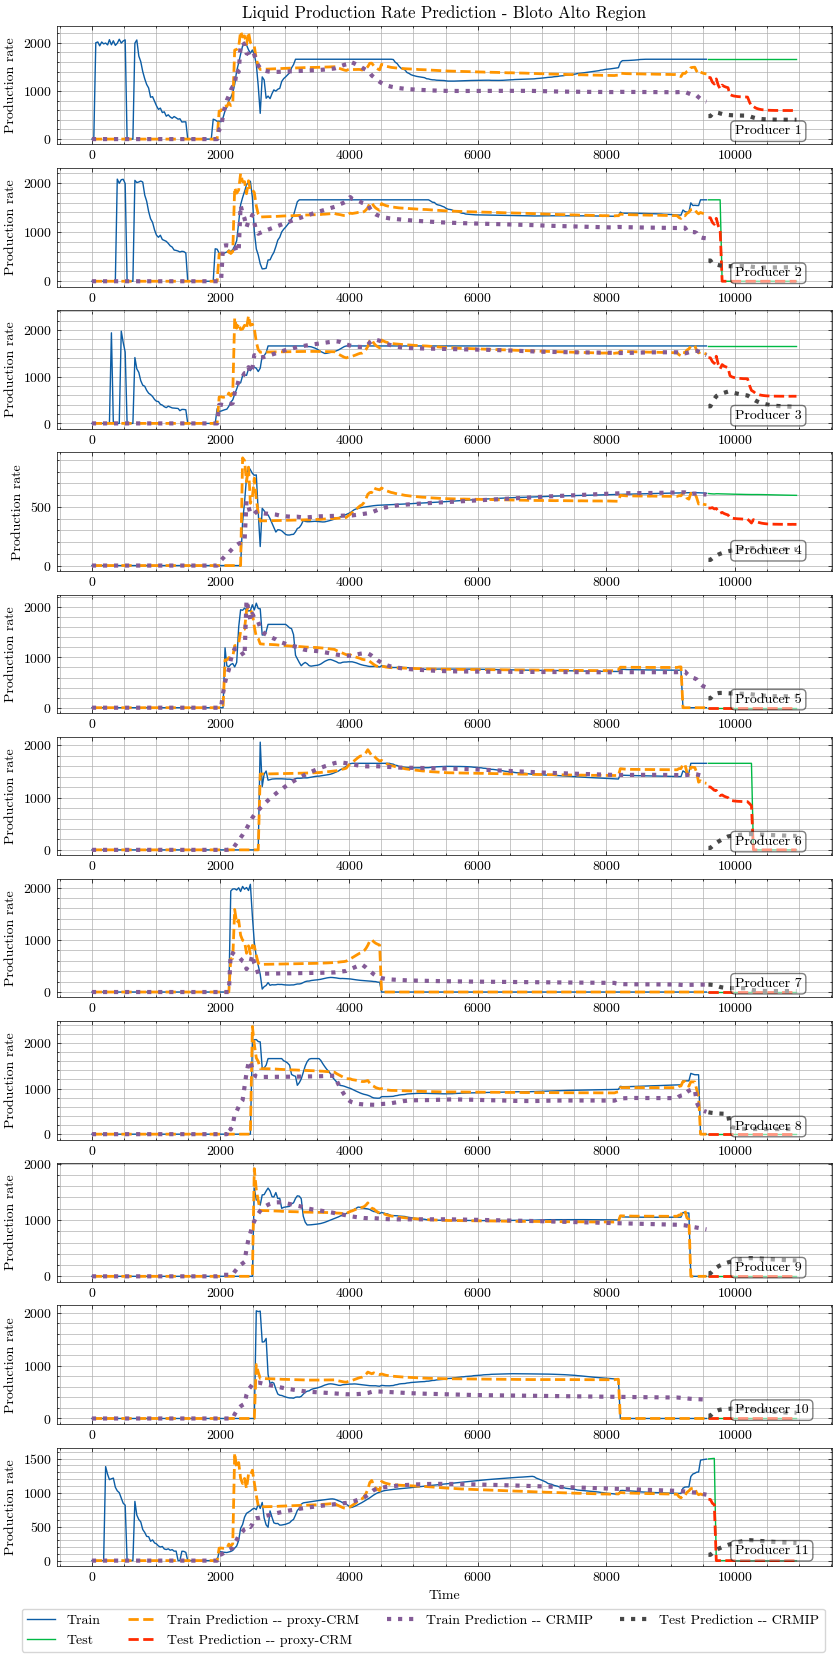

In [66]:
plt.style.use(['science', 'no-latex'])

fig, axes = plt.subplots(len(prod_bloto_alto.columns), figsize=(10, 20))
for i, p in enumerate(prod_bloto_alto):
    axes[i].plot(time_train , prod_train[:,i], label=f"Train")
    axes[i].plot(time_test, prod_test[:,i], label=f"Test")
    axes[i].plot(time_train, q_hat_train[:,i], ls="--", label=f"Train Prediction -- proxy-CRM", lw=2)
    axes[i].plot(time_test, q_hat_test[:,i], ls="--", label=f"Test Prediction -- proxy-CRM", lw=2)
    axes[i].plot(time_train, q_hat_crmip[:,i], ls=":", label=f"Train Prediction -- CRMIP", lw=3)
    axes[i].plot(time_test, q_hat_crmip_test[:,i], ls=":", label=f"Test Prediction -- CRMIP", lw=3)
    axes[i].set(ylabel="Production rate")
    axes[i].annotate(f"Producer {p+1}", xy=(10000, 100), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.5))
    axes[i].grid(visible=True, which='both')
axes[i].set(xlabel="Time")
axes[0].set(title='Liquid Production Rate Prediction - Bloto Alto Region')

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

In [10]:
connectivity = pd.DataFrame(
    proxy_crm.lambda_ip.reshape((prod_bloto_alto.shape[1], inj_bloto_alto.shape[1])),
    index=prod_bloto_alto.columns.rename("Producer"),
    columns=inj_bloto_alto.columns.rename("Injector"),
)
connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3,4,5,6,7,8,9,10
Injector,,,,,,,,,,,
0,0.011,0.0,0.0,0.084,0.084,0.29,0.023,0.17,0.22,0.15,0.0
1,0.15,0.16,0.053,0.0,0.11,0.091,0.0,0.089,0.054,0.02,0.0
2,0.18,0.15,0.22,0.026,0.13,0.051,0.018,0.19,0.071,0.093,0.16
3,0.093,0.056,0.033,0.0,0.058,0.08,0.0,0.07,0.035,0.0,0.0
4,0.079,0.075,0.077,0.098,0.019,0.14,0.058,0.026,0.066,0.072,0.025
5,0.0,0.0,0.0,0.0,0.0029,0.11,0.0,0.0,0.045,0.0,0.0
6,0.21,0.25,0.31,0.0,0.038,0.0,0.19,0.0,0.0,0.0,0.25
7,0.015,0.0,0.051,0.0032,0.17,0.046,0.0,0.14,0.11,0.09,0.0
8,0.061,0.025,0.11,0.0,0.11,0.0,0.0,0.12,0.051,0.0,0.0


In [33]:
def rmse(test, pred):
  original_rmse = np.sqrt(((test-pred)**2/len(test)).sum())
  return original_rmse

result=[]
for j in range(prod_bloto_alto.shape[1]):
  result.append(np.array(rmse(prod_test[:,j], q_hat_test[:,j])))

print(f'Test Prediction RMSE of Bloto Alto using proxy-CRM:\n{np.array(result)}')

Test Prediction RMSE of Bloto Alto using proxy-CRM:
[884.80163698 181.4980082  857.63392515 216.6160271    0.
 466.22118096   0.           0.           0.           0.
 187.07341319]


In [46]:
result=[]
for j in range(prod_bloto_alto.shape[1]):
  result.append(np.array(rmse(prod_test[:,j], q_hat_crmip_test[:,j])))

print(f'Test Prediction RMSE of Bloto Alto using CRMIP:\n{np.array(result)}')

Test Prediction RMSE of Bloto Alto using CRMIP:
[1201.72009498  572.34375987 1168.62829509  477.44666027  254.61940523
 1036.43890291   67.92515572  246.59728308  274.28113259  151.1790623
  483.46486953]


In [36]:
result=[]
for j in range(prod_bloto_alto.shape[1]):
  result.append(np.array(rmse(prod_train[:,j], q_hat_train[:,j])))

print(f'Train Prediction RMSE of Bloto Alto using proxy-CRM:\n{np.array(result)}')

Train Prediction RMSE of Bloto Alto using proxy-CRM:
[570.38463525 506.20211927 363.57870009  64.06932756 150.75198359
  94.22251318 274.64184339 118.29611462  81.5911218  168.1551659
 297.19809456]


In [48]:
result=[]
for j in range(prod_bloto_alto.shape[1]):
  result.append(np.array(rmse(prod_train[:,j], q_hat_crmip[:,j])))

print(f'Train Prediction RMSE of Bloto Alto using CRMIP:\n{np.array(result)}')

Train Prediction RMSE of Bloto Alto using CRMIP:
[644.34284089 530.10120642 292.45811293  66.23011596 192.34933553
 152.65869418 302.8121525  286.04354536 194.58409496 318.13105689
 248.58291305]


In [ ]:
n_prod = prod_train.shape[1]
n_inj = inj_train.shape[1]
n_t = prod_bloto_alto.values.shape[0]

lambda_ip = np.tile(proxy_crm.lambda_ip.reshape((n_prod,n_inj)), (n_t,1,1))

mask = pCRM.sh_mask(prod_train)
result = pCRM.calc_sh_mask(lambda_ip, mask)

print(result[:,2,:])

BLOTO-BAIXO CASE

In [12]:
inj_train2 = inj_bloto_baixo.values[:train_size]
prod_train2 = prod_bloto_baixo.values[:train_size]
time_train2 = time.values[:train_size].astype(float)
bhp_train2 = bhp_bloto_baixo.values[:train_size]

inj_test2 = inj_bloto_baixo.values[train_size:]
prod_test2 = prod_bloto_baixo.values[train_size:]
time_test2 = time.values[train_size:].astype(float)
bhp_test2 = bhp_bloto_baixo.values[train_size:]

In [13]:
proxy_crm.fit(prod_train2, inj_train2, bhp_train2, time_train2[:,0], num_cores=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 9.928782708288669
        x: [ 1.099e-01  4.543e-01 ...  1.033e-01  1.043e-01]
      nit: 10
      jac: [ 3.790e-02 -1.224e-03 ... -1.937e-02 -2.037e-02]
     nfev: 228
     njev: 12
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>]

lambda_ip: [0.10989176 0.4542505  0.40655067 0.33433036 0.         0.42649288]
tau: [ 9.99998659 10.         10.        ]
lambda_prod: [1. 1. 1.]
tau_prim: [10. 10. 10.]
prod index: [0.10144639 0.10333798 0.10432823]


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   25.1s


In [55]:
q_hat_train2 = proxy_crm.predict()
q_hat_test2 = proxy_crm.predict(inj=inj_test2, time=time_test2[:,0].astype(float), prod = prod_test2, press = bhp_test2)

USING CRMIP

In [49]:
crm2 = CrmCompensated(tau_selection='per-pair', constraints='up-to one')
crm2.fit(prod_train2, bhp_train2, inj_train2, time_train2[:,0], num_cores=4)

In [57]:
q_hat_crmip2 = crm2.predict()
q_hat_crmip_test2 = crm2.predict(injection = inj_test2, time = time_test2[:,0].astype(float), production=prod_test2)

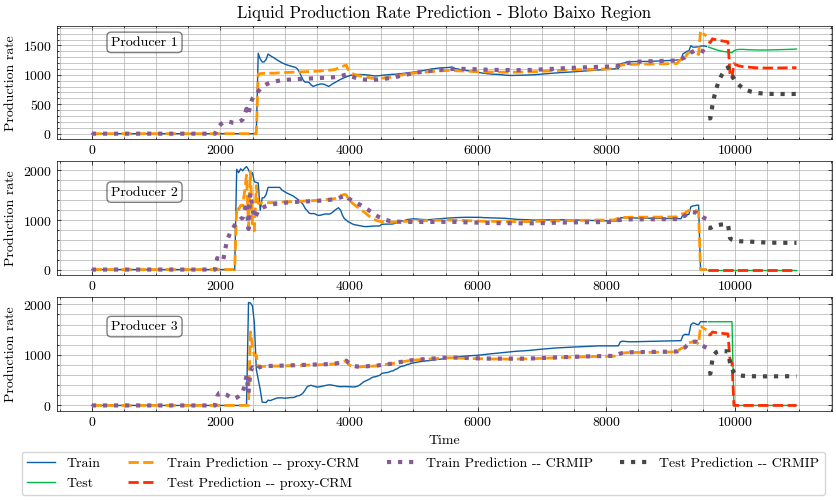

In [67]:
plt.style.use(['science', 'no-latex'])

fig, axes = plt.subplots(len(prod_bloto_baixo.columns), figsize=(10, 5))
for i, p in enumerate(prod_bloto_baixo):
    axes[i].plot(time_train , prod_train2[:,i], label=f"Train")
    axes[i].plot(time_test, prod_test2[:,i], label=f"Test")
    axes[i].plot(time_train, q_hat_train2[:,i], ls="--", label=f"Train Prediction -- proxy-CRM", lw=2)
    axes[i].plot(time_test, q_hat_test2[:,i], ls="--", label=f"Test Prediction -- proxy-CRM", lw=2)
    axes[i].plot(time_train, q_hat_crmip2[:,i], ls=":", label=f"Train Prediction -- CRMIP", lw=3)
    axes[i].plot(time_test, q_hat_crmip_test2[:,i], ls=":", label=f"Test Prediction -- CRMIP", lw=3)
    axes[i].set(ylabel="Production rate")
    axes[i].annotate(f"Producer {p+1}", xy=(300, 1500), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white', alpha=0.5))
    axes[i].grid(visible=True, which='both')
axes[i].set(xlabel="Time")
axes[0].set(title='Liquid Production Rate Prediction - Bloto Baixo Region')

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4, frameon=True)

In [16]:
connectivity = pd.DataFrame(
    proxy_crm.lambda_ip.reshape((prod_bloto_baixo.shape[1], inj_bloto_baixo.shape[1])),
    index=prod_bloto_baixo.columns.rename("Producer"),
    columns=inj_bloto_baixo.columns.rename("Injector"),
)
connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2
Injector,,,
0,0.11,0.41,0.0
1,0.45,0.33,0.43


In [35]:
result=[]
for j in range(prod_bloto_baixo.shape[1]):
  result.append(np.array(rmse(prod_test2[:,j], q_hat_test2[:,j])))

print(f'Test Prediction RMSE of Bloto Baixo using proxy-CRM:\n{np.array(result)}')

Test Prediction RMSE of Bloto Baixo using proxy-CRM:
[278.73956076   0.         198.9847705 ]


In [60]:
result=[]
for j in range(prod_bloto_baixo.shape[1]):
  result.append(np.array(rmse(prod_test2[:,j], q_hat_crmip_test2[:,j])))

print(f'Test Prediction RMSE of Bloto Baixo using CRMIP:\n{np.array(result)}')

Test Prediction RMSE of Bloto Baixo using CRMIP:
[707.21418419 650.79153256 630.14937645]


In [37]:
result=[]
for j in range(prod_bloto_baixo.shape[1]):
  result.append(np.array(rmse(prod_train2[:,j], q_hat_train2[:,j])))

print(f'Train Prediction RMSE of Bloto Baixo using proxy-CRM:\n{np.array(result)}')

Train Prediction RMSE of Bloto Baixo using proxy-CRM:
[ 90.26641317 185.64119523 286.37678945]


In [61]:
result=[]
for j in range(prod_bloto_baixo.shape[1]):
  result.append(np.array(rmse(prod_train2[:,j], q_hat_crmip2[:,j])))

print(f'Train Prediction RMSE of Bloto Baixo using CRMIP:\n{np.array(result)}')

Train Prediction RMSE of Bloto Baixo using CRMIP:
[138.45014701 265.96398947 306.56631304]
